In [4]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.2 MB/s eta 0:00:00


In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import optuna
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [7]:
from google.colab import files
uploaded = files.upload()

Saving dataset_outlier_removed.csv to dataset_outlier_removed.csv


In [9]:
import io
df = pd.read_csv(io.BytesIO(uploaded['dataset_outlier_removed.csv']))
df.columns
df
df.drop(columns=["outlier"])

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,3.0,145.0,233.0,0.0,2,150.0,0,2.3,3,0.0,6,0
1,67,1,4.0,160.0,286.0,0.0,2,108.0,1,1.5,2,0.0,3,1
2,67,1,4.0,120.0,229.0,0.0,2,129.0,1,2.6,2,2.0,7,1
3,37,1,3.0,130.0,250.0,0.0,0,187.0,0,3.5,3,0.0,3,0
4,41,0,2.0,130.0,204.0,0.0,2,172.0,0,1.4,1,0.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,3.0,110.0,264.0,0.0,0,132.0,0,1.2,2,0.0,7,1
299,68,1,4.0,144.0,193.0,0.0,0,141.0,0,3.4,2,2.0,7,1
300,57,1,4.0,130.0,131.0,0.0,0,115.0,1,1.2,2,1.0,7,1
301,57,0,2.0,130.0,236.0,0.0,2,174.0,0,0.0,2,1.0,3,1


In [10]:




# Separate features and target
X = df.drop(columns=["num"])  # Replace "target" with the actual column name
y = df["num"]

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE for class balancing
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Define the Wave Expansion Neural Network model
def create_wave_expansion_model(hidden_units, activation, learning_rate):
    model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(hidden_units, activation=activation),
        layers.Dense(hidden_units // 2, activation=activation),
        layers.Dense(1, activation="sigmoid")  # Output layer for binary classification
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Define objective function for Optuna (Hyperparameter tuning)
def objective(trial):
    hidden_units = trial.suggest_int("hidden_units", 16, 128)
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    model = create_wave_expansion_model(hidden_units, activation, learning_rate)
    model.fit(X_train_balanced, y_train_balanced, epochs=10, batch_size=32, verbose=0)  # Train for 10 epochs

    y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
    return accuracy_score(y_test, y_pred)

# Optimize hyperparameters using Tree-Structured Parzen Estimator (TPE)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=20)

# Train final model with best parameters
best_params = study.best_params
final_model = create_wave_expansion_model(best_params["hidden_units"], best_params["activation"], best_params["learning_rate"])
final_model.fit(X_train_balanced, y_train_balanced, epochs=50, batch_size=32, verbose=1)

# Predict and evaluate the model
y_pred_final = (final_model.predict(X_test_scaled) > 0.5).astype("int32")
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))


[I 2025-02-28 14:09:49,625] A new study created in memory with name: no-name-5da2afd2-491e-4b7b-ab21-24f135020451


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-02-28 14:09:54,176] Trial 0 finished with value: 0.8852459016393442 and parameters: {'hidden_units': 79, 'activation': 'relu', 'learning_rate': 0.0003747548779276884}. Best is trial 0 with value: 0.8852459016393442.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-02-28 14:09:56,620] Trial 1 finished with value: 0.8524590163934426 and parameters: {'hidden_units': 42, 'activation': 'tanh', 'learning_rate': 0.009588953367202962}. Best is trial 0 with value: 0.8852459016393442.


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-02-28 14:10:00,035] Trial 2 finished with value: 0.8688524590163934 and parameters: {'hidden_units': 47, 'activation': 'sigmoid', 'learning_rate': 0.003991739168857908}. Best is trial 0 with value: 0.8852459016393442.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-02-28 14:10:02,852] Trial 3 finished with value: 0.5081967213114754 and parameters: {'hidden_units': 29, 'activation': 'tanh', 'learning_rate': 0.00012102101586519473}. Best is trial 0 with value: 0.8852459016393442.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-02-28 14:10:05,322] Trial 4 finished with value: 0.9016393442622951 and parameters: {'hidden_units': 68, 'activation': 'sigmoid', 'learning_rate': 0.002542639030388223}. Best is trial 4 with value: 0.9016393442622951.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-02-28 14:10:07,865] Trial 5 finished with value: 0.7213114754098361 and parameters: {'hidden_units': 33, 'activation': 'tanh', 'learning_rate': 0.00025122528135098455}. Best is trial 4 with value: 0.9016393442622951.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


[I 2025-02-28 14:10:10,503] Trial 6 finished with value: 0.8524590163934426 and parameters: {'hidden_units': 104, 'activation': 'relu', 'learning_rate': 0.004360151513971593}. Best is trial 4 with value: 0.9016393442622951.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-02-28 14:10:13,408] Trial 7 finished with value: 0.8688524590163934 and parameters: {'hidden_units': 77, 'activation': 'tanh', 'learning_rate': 0.005191375431695605}. Best is trial 4 with value: 0.9016393442622951.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-02-28 14:10:15,710] Trial 8 finished with value: 0.8688524590163934 and parameters: {'hidden_units': 17, 'activation': 'tanh', 'learning_rate': 0.006376636118378788}. Best is trial 4 with value: 0.9016393442622951.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-02-28 14:10:18,096] Trial 9 finished with value: 0.8688524590163934 and parameters: {'hidden_units': 18, 'activation': 'tanh', 'learning_rate': 0.0008685578559180035}. Best is trial 4 with value: 0.9016393442622951.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-02-28 14:10:21,196] Trial 10 finished with value: 0.8688524590163934 and parameters: {'hidden_units': 113, 'activation': 'sigmoid', 'learning_rate': 0.001710973385236101}. Best is trial 4 with value: 0.9016393442622951.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-02-28 14:10:24,760] Trial 11 finished with value: 0.8524590163934426 and parameters: {'hidden_units': 72, 'activation': 'relu', 'learning_rate': 0.0006303334857874815}. Best is trial 4 with value: 0.9016393442622951.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-02-28 14:10:27,271] Trial 12 finished with value: 0.9016393442622951 and parameters: {'hidden_units': 74, 'activation': 'sigmoid', 'learning_rate': 0.0017194189323659988}. Best is trial 4 with value: 0.9016393442622951.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-02-28 14:10:29,664] Trial 13 finished with value: 0.8852459016393442 and parameters: {'hidden_units': 60, 'activation': 'sigmoid', 'learning_rate': 0.0016874013625318555}. Best is trial 4 with value: 0.9016393442622951.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


[I 2025-02-28 14:10:32,501] Trial 14 finished with value: 0.8852459016393442 and parameters: {'hidden_units': 100, 'activation': 'sigmoid', 'learning_rate': 0.002032186024309323}. Best is trial 4 with value: 0.9016393442622951.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


[I 2025-02-28 14:10:40,874] Trial 15 finished with value: 0.8852459016393442 and parameters: {'hidden_units': 87, 'activation': 'sigmoid', 'learning_rate': 0.0027632842142482545}. Best is trial 4 with value: 0.9016393442622951.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-02-28 14:10:43,508] Trial 16 finished with value: 0.8688524590163934 and parameters: {'hidden_units': 60, 'activation': 'sigmoid', 'learning_rate': 0.0011633377620048175}. Best is trial 4 with value: 0.9016393442622951.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-02-28 14:10:45,885] Trial 17 finished with value: 0.8852459016393442 and parameters: {'hidden_units': 60, 'activation': 'sigmoid', 'learning_rate': 0.000559821487982018}. Best is trial 4 with value: 0.9016393442622951.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-02-28 14:10:48,580] Trial 18 finished with value: 0.8524590163934426 and parameters: {'hidden_units': 125, 'activation': 'sigmoid', 'learning_rate': 0.0029132966776121605}. Best is trial 4 with value: 0.9016393442622951.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-02-28 14:10:51,511] Trial 19 finished with value: 0.8852459016393442 and parameters: {'hidden_units': 92, 'activation': 'sigmoid', 'learning_rate': 0.0011397937847251456}. Best is trial 4 with value: 0.9016393442622951.


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5566 - loss: 0.6985
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5942 - loss: 0.6609 
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8089 - loss: 0.6220 
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7777 - loss: 0.5854 
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8293 - loss: 0.5198 
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8458 - loss: 0.4631 
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8308 - loss: 0.4353 
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8146 - loss: 0.4235 
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8193 - loss: 0.3977 
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8358 - loss: 0.3725 
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8222 - loss: 0.4019 
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8217 - loss: 0.3767 
Ep

added 10 fold cross validation

In [15]:


# Separate features and target (replace "target" with your column name for target variable)
X = df.drop(columns=["num"])
y = df["num"]

# Scaling: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# SMOTE: Apply Synthetic Minority Over-sampling Technique to balance the dataset
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

# Build the Wave Expansion Neural Network model
def create_wave_expansion_model(hidden_units, activation, learning_rate):
    model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(hidden_units, activation=activation),
        layers.Dense(hidden_units // 2, activation=activation),
        layers.Dense(1, activation="sigmoid")  # Output layer for binary classification
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Objective function for Optuna hyperparameter tuning
def objective(trial):
    hidden_units = trial.suggest_int("hidden_units", 32, 128)
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)

    model = create_wave_expansion_model(hidden_units, activation, learning_rate)

    # Use 10-Fold Cross Validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []

    for train_idx, val_idx in kf.split(X_balanced, y_balanced):
        X_train_cv, X_val_cv = X_balanced[train_idx], X_balanced[val_idx]
        y_train_cv, y_val_cv = y_balanced[train_idx], y_balanced[val_idx]

        model.fit(X_train_cv, y_train_cv, epochs=10, batch_size=32, verbose=0)

        # Evaluate on the validation set
        y_pred_cv = (model.predict(X_val_cv) > 0.5).astype("int32")
        accuracies.append(accuracy_score(y_val_cv, y_pred_cv))

    # Return the average accuracy of the 10 folds
    return np.mean(accuracies)

# Hyperparameter optimization using Optuna's Tree-Structured Parzen Estimator (TPE)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)  # You can adjust n_trials as needed

# Print the best hyperparameters found by Optuna
print(f"Best Hyperparameters: {study.best_params}")

# Train the final model with the best hyperparameters found by Optuna
best_params = study.best_params
final_model = create_wave_expansion_model(best_params["hidden_units"], best_params["activation"], best_params["learning_rate"])

# Fit the model using the full balanced dataset
final_model.fit(X_balanced, y_balanced, epochs=50, batch_size=32, verbose=1)

# Evaluate the final model on the entire balanced dataset
y_pred_final = (final_model.predict(X_balanced) > 0.5).astype("int32")

# Print classification report
print("\nClassification Report:\n", classification_report(y_balanced, y_pred_final))


[I 2025-02-28 14:22:10,369] A new study created in memory with name: no-name-39d0155f-4deb-42da-830b-b6c7812dfa24
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-02-28 14:22:23,997] Trial 0 finished with value: 0.8601325757575757 and parameters: {'hidden_units': 98, 'activation': 'relu', 'learning_rate': 0.00018314836007064192}. Best is trial 0 with value: 0.8601325757575757.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-02-28 14:22:36,225] Trial 1 finished with value: 0.6928977272727272 and parameters: {'hidden_units': 99, 'activation': 'sigmoid', 'learning_rate': 2.842313961838997e-05}. Best is trial 0 with value: 0.8601325757575757.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-02-28 14:22:48,141] Trial 2 finished with value: 0.662405303030303 and parameters: {'hidden_units': 123, 'activation': 'sigmoid', 'learning_rate': 1.6353920045898527e-05}. Best is trial 0 with value: 0.8601325757575757.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-02-28 14:23:00,588] Trial 3 finished with value: 0.9696969696969697 and parameters: {'hidden_units': 118, 'activation': 'relu', 'learning_rate': 0.008971952496750316}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-02-28 14:23:13,080] Trial 4 finished with value: 0.8234848484848485 and parameters: {'hidden_units': 54, 'activation': 'sigmoid', 'learning_rate': 0.0018557001603504645}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2025-02-28 14:23:28,937] Trial 5 finished with value: 0.8142992424242423 and parameters: {'hidden_units': 67, 'activation': 'tanh', 'learning_rate': 6.287291334648211e-05}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-02-28 14:23:40,898] Trial 6 finished with value: 0.8572916666666666 and parameters: {'hidden_units': 115, 'activation': 'relu', 'learning_rate': 0.00019085430039092756}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-02-28 14:23:52,867] Trial 7 finished with value: 0.8571969696969696 and parameters: {'hidden_units': 109, 'activation': 'relu', 'learning_rate': 0.00016457021508515282}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-02-28 14:24:05,185] Trial 8 finished with value: 0.48806818181818185 and parameters: {'hidden_units': 42, 'activation': 'relu', 'learning_rate': 1.2194378547528244e-05}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-02-28 14:24:17,302] Trial 9 finished with value: 0.774905303030303 and parameters: {'hidden_units': 117, 'activation': 'tanh', 'learning_rate': 1.4673676412106061e-05}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-02-28 14:24:29,753] Trial 10 finished with value: 0.9636363636363636 and parameters: {'hidden_units': 81, 'activation': 'relu', 'learning_rate': 0.00990511455412192}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-02-28 14:24:43,142] Trial 11 finished with value: 0.9696969696969697 and parameters: {'hidden_units': 82, 'activation': 'relu', 'learning_rate': 0.008728290170806674}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-02-28 14:24:57,955] Trial 12 finished with value: 0.9606060606060606 and parameters: {'hidden_units': 81, 'activation': 'relu', 'learning_rate': 0.00784591242192149}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-02-28 14:25:11,239] Trial 13 finished with value: 0.9393939393939394 and parameters: {'hidden_units': 92, 'activation': 'relu', 'learning_rate': 0.001246556132012818}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-02-28 14:25:24,516] Trial 14 finished with value: 0.9028409090909092 and parameters: {'hidden_units': 34, 'activation': 'relu', 'learning_rate': 0.0018282192109816712}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-02-28 14:25:37,244] Trial 15 finished with value: 0.9272727272727274 and parameters: {'hidden_units': 65, 'activation': 'tanh', 'learning_rate': 0.003966058083795902}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-02-28 14:25:50,609] Trial 16 finished with value: 0.9089962121212121 and parameters: {'hidden_units': 128, 'activation': 'relu', 'learning_rate': 0.0006945370163789683}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-02-28 14:26:03,167] Trial 17 finished with value: 0.9666666666666668 and parameters: {'hidden_units': 67, 'activation': 'relu', 'learning_rate': 0.004434278624269246}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-02-28 14:26:16,777] Trial 18 finished with value: 0.8357007575757575 and parameters: {'hidden_units': 107, 'activation': 'sigmoid', 'learning_rate': 0.0005937040211882341}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-02-28 14:26:29,586] Trial 19 finished with value: 0.9333333333333332 and parameters: {'hidden_units': 89, 'activation': 'tanh', 'learning_rate': 0.003419235144478873}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-02-28 14:26:42,165] Trial 20 finished with value: 0.9666666666666666 and parameters: {'hidden_units': 55, 'activation': 'relu', 'learning_rate': 0.005728149970307258}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-02-28 14:26:55,066] Trial 21 finished with value: 0.9636363636363636 and parameters: {'hidden_units': 71, 'activation': 'relu', 'learning_rate': 0.003386953223791393}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-02-28 14:27:08,539] Trial 22 finished with value: 0.9575757575757576 and parameters: {'hidden_units': 56, 'activation': 'relu', 'learning_rate': 0.005422867966649184}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-02-28 14:27:19,766] Trial 23 finished with value: 0.9636363636363636 and parameters: {'hidden_units': 75, 'activation': 'relu', 'learning_rate': 0.009798407661863373}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-02-28 14:27:32,027] Trial 24 finished with value: 0.9424242424242424 and parameters: {'hidden_units': 87, 'activation': 'relu', 'learning_rate': 0.0022354779398409304}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-02-28 14:27:44,626] Trial 25 finished with value: 0.899810606060606 and parameters: {'hidden_units': 60, 'activation': 'relu', 'learning_rate': 0.0009086527091407741}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-02-28 14:27:56,446] Trial 26 finished with value: 0.9575757575757576 and parameters: {'hidden_units': 46, 'activation': 'relu', 'learning_rate': 0.004316879606207713}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-02-28 14:28:08,040] Trial 27 finished with value: 0.8694128787878788 and parameters: {'hidden_units': 100, 'activation': 'relu', 'learning_rate': 0.0004240928046133396}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-02-28 14:28:21,360] Trial 28 finished with value: 0.8203598484848484 and parameters: {'hidden_units': 78, 'activation': 'sigmoid', 'learning_rate': 0.0025035446113125352}. Best is trial 3 with value: 0.9696969696969697.
<ipython-input-15-3dba7a667232>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-02-28 14:28:36,867] Trial 29 finished with value: 0.9575757575757576 and parameters: {'hidden_units': 105, 'activation': 'tanh', 'learning_rate': 0.006584045425574735}. Best is trial 3 with value: 0.9696969696969697.


Best Hyperparameters: {'hidden_units': 118, 'activation': 'relu', 'learning_rate': 0.008971952496750316}
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6778 - loss: 0.5552
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8371 - loss: 0.3561 
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8850 - loss: 0.2813 
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8921 - loss: 0.2628 
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8946 - loss: 0.2514 
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9361 - loss: 0.1815 
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9431 - loss: 0.1713 
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9577 - loss: 0.1346 
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9644 - loss: 0.1155 
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9747 - loss: 0.0862 
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms

[I 2025-02-28 15:59:31,503] A new study created in memory with name: no-name-6468534b-2451-48b8-9a97-aeea1f63730e
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-02-28 15:59:46,367] Trial 0 finished with value: 0.8816287878787878 and parameters: {'hidden_units': 125, 'activation': 'relu', 'learning_rate': 0.00036613797175675855}. Best is trial 0 with value: 0.8816287878787878.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-02-28 15:59:59,737] Trial 1 finished with value: 0.7689393939393939 and parameters: {'hidden_units': 125, 'activation': 'sigmoid', 'learning_rate': 1.9644531073643795e-05}. Best is trial 0 with value: 0.8816287878787878.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-02-28 16:00:12,747] Trial 2 finished with value: 0.6200757575757576 and parameters: {'hidden_units': 104, 'activation': 'sigmoid', 'learning_rate': 2.548232381742508e-05}. Best is trial 0 with value: 0.8816287878787878.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2025-02-28 16:00:25,645] Trial 3 finished with value: 0.8692234848484848 and parameters: {'hidden_units': 89, 'activation': 'relu', 'learning_rate': 0.00051822336531481}. Best is trial 0 with value: 0.8816287878787878.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-02-28 16:00:37,197] Trial 4 finished with value: 0.8296401515151516 and parameters: {'hidden_units': 56, 'activation': 'sigmoid', 'learning_rate': 0.0014051406158306246}. Best is trial 0 with value: 0.8816287878787878.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-02-28 16:00:50,107] Trial 5 finished with value: 0.881534090909091 and parameters: {'hidden_units': 53, 'activation': 'relu', 'learning_rate': 0.0006629392688544608}. Best is trial 0 with value: 0.8816287878787878.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2025-02-28 16:01:01,292] Trial 6 finished with value: 0.9271780303030303 and parameters: {'hidden_units': 83, 'activation': 'relu', 'learning_rate': 0.001122882194113032}. Best is trial 6 with value: 0.9271780303030303.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-02-28 16:01:13,118] Trial 7 finished with value: 0.9515151515151515 and parameters: {'hidden_units': 54, 'activation': 'relu', 'learning_rate': 0.0046554409392189095}. Best is trial 7 with value: 0.9515151515151515.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-02-28 16:01:25,947] Trial 8 finished with value: 0.8418560606060606 and parameters: {'hidden_units': 45, 'activation': 'tanh', 'learning_rate': 0.00063710730024618}. Best is trial 7 with value: 0.9515151515151515.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2025-02-28 16:01:38,185] Trial 9 finished with value: 0.771875 and parameters: {'hidden_units': 107, 'activation': 'tanh', 'learning_rate': 1.6969973094133168e-05}. Best is trial 7 with value: 0.9515151515151515.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-02-28 16:01:50,081] Trial 10 finished with value: 0.9606060606060606 and parameters: {'hidden_units': 32, 'activation': 'relu', 'learning_rate': 0.008972053848021268}. Best is trial 10 with value: 0.9606060606060606.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-02-28 16:02:02,400] Trial 11 finished with value: 0.9606060606060606 and parameters: {'hidden_units': 32, 'activation': 'relu', 'learning_rate': 0.009112108683677539}. Best is trial 10 with value: 0.9606060606060606.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-02-28 16:02:15,305] Trial 12 finished with value: 0.9545454545454545 and parameters: {'hidden_units': 34, 'activation': 'relu', 'learning_rate': 0.00965373969223011}. Best is trial 10 with value: 0.9606060606060606.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-02-28 16:02:27,131] Trial 13 finished with value: 0.9271780303030303 and parameters: {'hidden_units': 35, 'activation': 'relu', 'learning_rate': 0.0034604606250871616}. Best is trial 10 with value: 0.9606060606060606.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2025-02-28 16:02:38,957] Trial 14 finished with value: 0.8508522727272727 and parameters: {'hidden_units': 67, 'activation': 'relu', 'learning_rate': 0.00010894664423666587}. Best is trial 10 with value: 0.9606060606060606.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-02-28 16:02:49,943] Trial 15 finished with value: 0.9545454545454547 and parameters: {'hidden_units': 69, 'activation': 'tanh', 'learning_rate': 0.008751195633729262}. Best is trial 10 with value: 0.9606060606060606.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-02-28 16:03:02,727] Trial 16 finished with value: 0.7566287878787878 and parameters: {'hidden_units': 33, 'activation': 'relu', 'learning_rate': 0.00011274966932360553}. Best is trial 10 with value: 0.9606060606060606.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2025-02-28 16:03:15,184] Trial 17 finished with value: 0.9271780303030303 and parameters: {'hidden_units': 44, 'activation': 'relu', 'learning_rate': 0.0026768310974409825}. Best is trial 10 with value: 0.9606060606060606.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-02-28 16:03:32,124] Trial 18 finished with value: 0.887784090909091 and parameters: {'hidden_units': 70, 'activation': 'tanh', 'learning_rate': 0.0018538309988200409}. Best is trial 10 with value: 0.9606060606060606.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-02-28 16:03:46,281] Trial 19 finished with value: 0.8357954545454545 and parameters: {'hidden_units': 44, 'activation': 'sigmoid', 'learning_rate': 0.005074868970895615}. Best is trial 10 with value: 0.9606060606060606.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-02-28 16:03:59,791] Trial 20 finished with value: 0.8206439393939394 and parameters: {'hidden_units': 62, 'activation': 'relu', 'learning_rate': 0.00011338620985014337}. Best is trial 10 with value: 0.9606060606060606.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-02-28 16:04:12,520] Trial 21 finished with value: 0.9636363636363636 and parameters: {'hidden_units': 77, 'activation': 'tanh', 'learning_rate': 0.00827050534091262}. Best is trial 21 with value: 0.9636363636363636.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-02-28 16:04:25,293] Trial 22 finished with value: 0.9484848484848485 and parameters: {'hidden_units': 95, 'activation': 'tanh', 'learning_rate': 0.00966422810892462}. Best is trial 21 with value: 0.9636363636363636.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-02-28 16:04:37,454] Trial 23 finished with value: 0.9424242424242424 and parameters: {'hidden_units': 76, 'activation': 'tanh', 'learning_rate': 0.005614526905006406}. Best is trial 21 with value: 0.9636363636363636.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-02-28 16:04:49,108] Trial 24 finished with value: 0.8907196969696969 and parameters: {'hidden_units': 42, 'activation': 'tanh', 'learning_rate': 0.002286656957968179}. Best is trial 21 with value: 0.9636363636363636.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-02-28 16:05:01,159] Trial 25 finished with value: 0.9393939393939394 and parameters: {'hidden_units': 105, 'activation': 'tanh', 'learning_rate': 0.006341712565100281}. Best is trial 21 with value: 0.9636363636363636.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2025-02-28 16:05:14,096] Trial 26 finished with value: 0.9333333333333332 and parameters: {'hidden_units': 49, 'activation': 'relu', 'learning_rate': 0.0031243603119363614}. Best is trial 21 with value: 0.9636363636363636.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-02-28 16:05:26,590] Trial 27 finished with value: 0.8417613636363637 and parameters: {'hidden_units': 61, 'activation': 'sigmoid', 'learning_rate': 0.0011278200223653963}. Best is trial 21 with value: 0.9636363636363636.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2025-02-28 16:05:39,063] Trial 28 finished with value: 0.8265151515151515 and parameters: {'hidden_units': 117, 'activation': 'tanh', 'learning_rate': 0.0002162193423760786}. Best is trial 21 with value: 0.9636363636363636.
<ipython-input-17-2eee75a35aef>:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-02-28 16:05:50,881] Trial 29 finished with value: 0.9514204545454547 and parameters: {'hidden_units': 39, 'activation': 'relu', 'learning_rate': 0.00412422380865109}. Best is trial 21 with value: 0.9636363636363636.


Best Hyperparameters: {'hidden_units': 77, 'activation': 'tanh', 'learning_rate': 0.00827050534091262}
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7320 - loss: 0.5158
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8295 - loss: 0.3453 
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8388 - loss: 0.3365 
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8630 - loss: 0.3401 
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8591 - loss: 0.3130 
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8285 - loss: 0.3470 
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8618 - loss: 0.3000 
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9018 - loss: 0.2620 
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8677 - loss: 0.3074 
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9168 - loss: 0.2313 
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

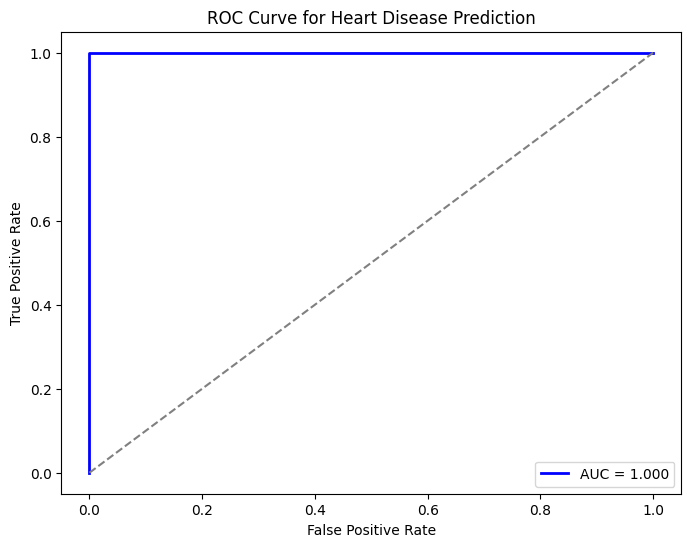

AUC Score: 1.000


In [17]:


# Separate features and target (replace "target" with your column name for target variable)
X = df.drop(columns=["num"])
y = df["num"]

# Scaling: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# SMOTE: Apply Synthetic Minority Over-sampling Technique to balance the dataset
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

# Build the Wave Expansion Neural Network model
def create_wave_expansion_model(hidden_units, activation, learning_rate):
    model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(hidden_units, activation=activation),
        layers.Dense(hidden_units // 2, activation=activation),
        layers.Dense(1, activation="sigmoid")  # Output layer for binary classification
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Objective function for Optuna hyperparameter tuning
def objective(trial):
    hidden_units = trial.suggest_int("hidden_units", 32, 128)
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)

    model = create_wave_expansion_model(hidden_units, activation, learning_rate)

    # Use 10-Fold Cross Validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []

    for train_idx, val_idx in kf.split(X_balanced, y_balanced):
        X_train_cv, X_val_cv = X_balanced[train_idx], X_balanced[val_idx]
        y_train_cv, y_val_cv = y_balanced[train_idx], y_balanced[val_idx]

        model.fit(X_train_cv, y_train_cv, epochs=10, batch_size=32, verbose=0)

        # Evaluate on the validation set
        y_pred_cv = (model.predict(X_val_cv) > 0.5).astype("int32")
        accuracies.append(accuracy_score(y_val_cv, y_pred_cv))

    # Return the average accuracy of the 10 folds
    return np.mean(accuracies)

# Hyperparameter optimization using Optuna's Tree-Structured Parzen Estimator (TPE)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)  # You can adjust n_trials as needed

# Print the best hyperparameters found by Optuna
print(f"Best Hyperparameters: {study.best_params}")

# Train the final model with the best hyperparameters found by Optuna
best_params = study.best_params
final_model = create_wave_expansion_model(best_params["hidden_units"], best_params["activation"], best_params["learning_rate"])

# Fit the model using the full balanced dataset
final_model.fit(X_balanced, y_balanced, epochs=50, batch_size=32, verbose=1)

# Evaluate the final model on the entire balanced dataset
y_pred_final = (final_model.predict(X_balanced) > 0.5).astype("int32")

# Print classification report
print("\nClassification Report:\n", classification_report(y_balanced, y_pred_final))
# Get predicted probabilities
y_prob = final_model.predict(X_balanced)  # Probabilities (not binary predictions)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_balanced, y_prob)  # Compute False Positive & True Positive Rates
roc_auc = auc(fpr, tpr)  # Compute AUC Score

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.3f}")  # ROC Curve
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Heart Disease Prediction")
plt.legend(loc="lower right")
plt.show()

# Print AUC Score
print(f"AUC Score: {roc_auc:.3f}")



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


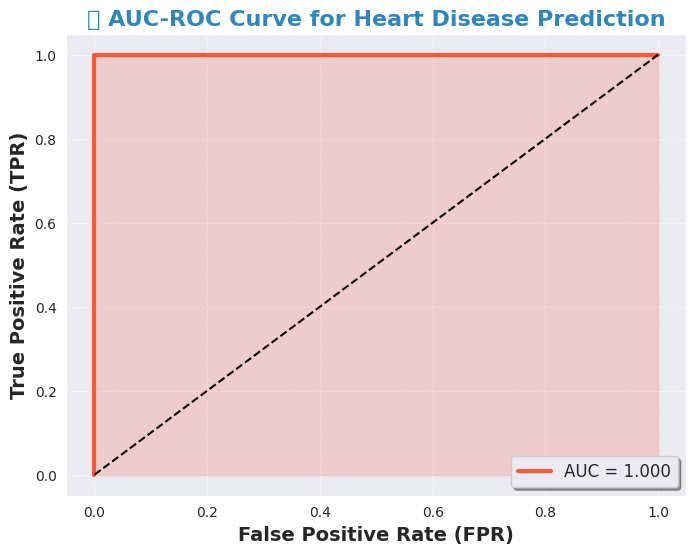

AUC Score: 1.000


In [19]:
# Get predicted probabilities (not binary labels)
y_prob = final_model.predict(X_balanced)

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_balanced, y_prob)  # False Positive & True Positive Rates
roc_auc = auc(fpr, tpr)  # Compute AUC Score

# Set Seaborn style for a professional look
sns.set_style("darkgrid")

# Create the ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="#FF5733", lw=3, label=f"AUC = {roc_auc:.3f}")  # AUC Curve
plt.plot([0, 1], [0, 1], color="black", linestyle="dashed", linewidth=1.5)  # Random classifier line
plt.fill_between(fpr, tpr, alpha=0.2, color="#FF5733")  # Highlight AUC region

# Customize plot aesthetics
plt.xlabel("False Positive Rate (FPR)", fontsize=14, fontweight="bold")
plt.ylabel("True Positive Rate (TPR)", fontsize=14, fontweight="bold")
plt.title("📈 AUC-ROC Curve for Heart Disease Prediction", fontsize=16, fontweight="bold", color="#2E86C1")
plt.legend(loc="lower right", fontsize=12, fancybox=True, shadow=True)
plt.grid(True, linestyle="--", alpha=0.6)

# Show the ROC Curve
plt.show()

# Print AUC Score
print(f"AUC Score: {roc_auc:.3f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


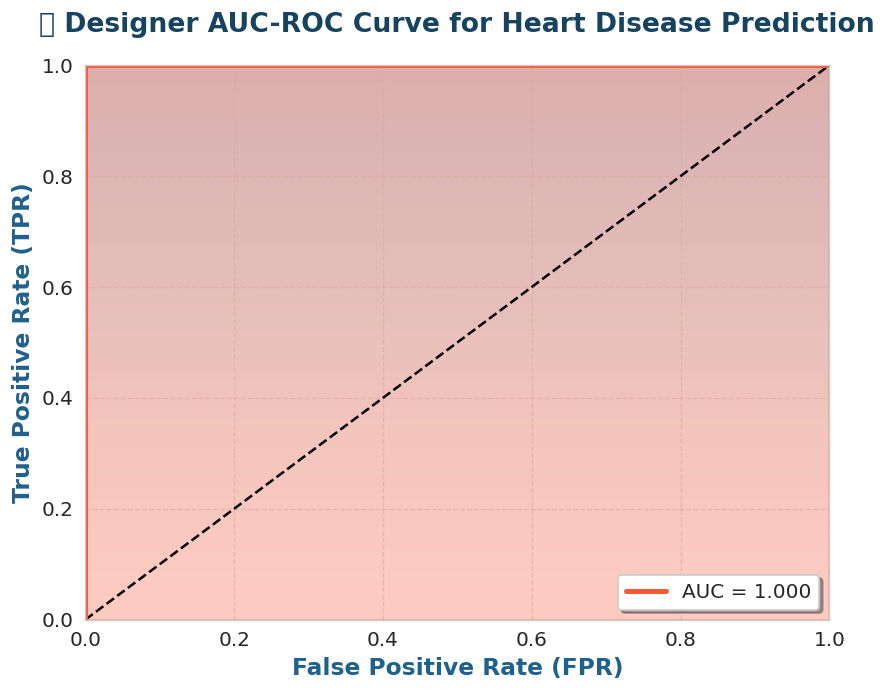

🔥 AUC Score: 1.000


In [20]:
# Get predicted probabilities (not binary labels)
y_prob = final_model.predict(X_balanced)

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_balanced, y_prob)  # False Positive & True Positive Rates
roc_auc = auc(fpr, tpr)  # Compute AUC Score

# Set Seaborn style for a stylish look
sns.set_style("whitegrid")

# Create figure
fig, ax = plt.subplots(figsize=(8, 6), dpi=120)

# Add gradient background
gradient = np.linspace(0, 1, 100).reshape(-1, 1)
ax.imshow(gradient, extent=[0, 1, 0, 1], origin="lower", cmap="Blues", alpha=0.2, aspect="auto")

# Plot ROC Curve
ax.plot(fpr, tpr, color="#FF5733", lw=3, label=f"AUC = {roc_auc:.3f}", zorder=2)
ax.fill_between(fpr, tpr, alpha=0.3, color="#FF5733")  # Highlight AUC region
ax.plot([0, 1], [0, 1], color="black", linestyle="dashed", linewidth=1.5, zorder=1)  # Random classifier line

# Customize plot aesthetics
ax.set_xlabel("False Positive Rate (FPR)", fontsize=14, fontweight="bold", color="#1F618D")
ax.set_ylabel("True Positive Rate (TPR)", fontsize=14, fontweight="bold", color="#1F618D")
ax.set_title("🎨 Designer AUC-ROC Curve for Heart Disease Prediction", fontsize=16, fontweight="bold", color="#154360", pad=20)

# Add grid & legend with style
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(loc="lower right", fontsize=12, fancybox=True, shadow=True, facecolor="white")

# Enhance x/y ticks with bold style
ax.tick_params(axis="both", which="major", labelsize=12, color="black")

# Show the ROC Curve
plt.show()

# Print AUC Score
print(f"🔥 AUC Score: {roc_auc:.3f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


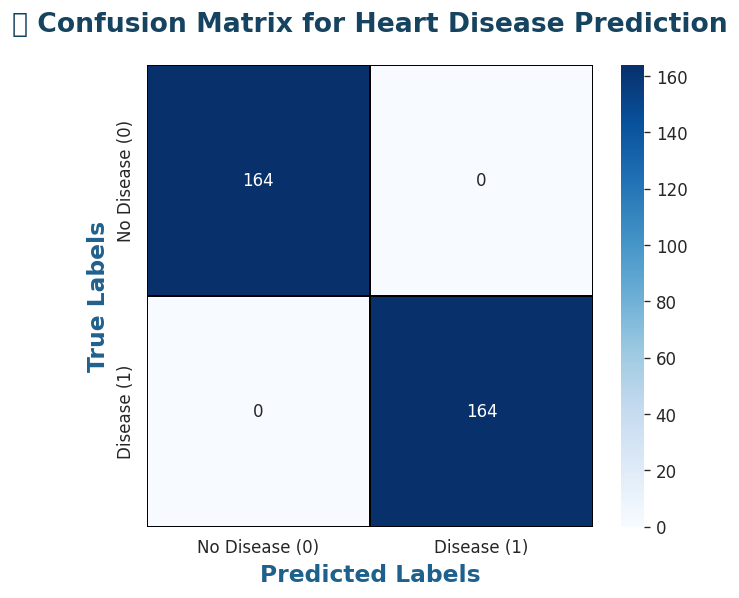

In [22]:
# Get predicted labels (convert probabilities to 0 or 1)
y_pred_final = (final_model.predict(X_balanced) > 0.5).astype("int32")

# Compute Confusion Matrix
cm = confusion_matrix(y_balanced, y_pred_final)

# Define Labels
labels = ["No Disease (0)", "Disease (1)"]

# Set Seaborn Style for Better Visualization
sns.set_style("whitegrid")

# Create a Figure
plt.figure(figsize=(6, 5), dpi=120)

# Create a Heatmap for Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, linewidths=1, linecolor="black")

# Add Titles and Labels
plt.xlabel("Predicted Labels", fontsize=14, fontweight="bold", color="#1F618D")
plt.ylabel("True Labels", fontsize=14, fontweight="bold", color="#1F618D")
plt.title("📊 Confusion Matrix for Heart Disease Prediction", fontsize=16, fontweight="bold", color="#154360", pad=20)

# Show the Confusion Matrix
plt.show()
